What does an infinitely wide recurrent neural network look like? We will calculate its Neural Tangent Kernel in this notebook, according to [our paper](https://arxiv.org/abs/2006.14548), so you can find out yourself!

In [1]:
import numpy as np
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
from utils import clone_grads, paramdot, VErf3, VDerErf3

We will consider the RNN with forward and backward propagation defined by

![RNN.png](images/RNN.png)

We will sample

![RNN_sampling.png](images/RNN_sampling.png)

# Finite-Width Neural Network

In [3]:
import torch
import torch.nn as nn
class SimpleRNNClassifier(nn.Module):
    def __init__(self, indim, statedim, outdim=1, nonlin=torch.erf, varu=1, varw=1, varb=0, varv=1,
                avgpool=False, debug=False):
        super().__init__()
        self.varu = varu
        self.varw = varw
        self.varb = varb
        self.varv = varv
        self.nonlin = nonlin
        self.avgpool = avgpool
        self.debug = debug
        self.W = nn.Parameter(torch.randn(statedim, statedim))
        self.U = nn.Parameter(torch.randn(indim, statedim))
        self.b = nn.Parameter(torch.randn(statedim))
        self.v = nn.Parameter(torch.randn(statedim, outdim))
        self.randomize()
        
    def forward(self, inp, initstate=0):
        '''
        Input:
            inp: (batchsize, seqlen, indim)
        Output:
            out: (batchsize, outdim)
        '''
        indim = self.U.shape[0]
        statedim = self.U.shape[1]
        embed = torch.einsum(
            'ijk,kl->ijl', inp, self.U) / np.sqrt(indim) + self.b
        seqlen = inp.shape[1]
        state = initstate
        self._states = []
        self.hs = []
        for i in range(seqlen):
            h = embed[:, i] + state
            state = self.nonlin(h)
            self._states.append(state)
            if self.debug:
                state.retain_grad()
            # _states[i] = s^{i+1}
                self.hs.append(h)
            if i < seqlen - 1:
                state = state @ self.W / np.sqrt(statedim)
            else:
                if self.avgpool:
                    meanstate = sum(self._states) / len(self._states)
                    return meanstate @ self.v / np.sqrt(statedim)
                else:
                    return state @ self.v / np.sqrt(statedim)
        
    def randomize(self, varu=None, varw=None, varb=None, varv=None):
        varu = varu or self.varu
        varw = varw or self.varw
        varb = varb or self.varb
        varv = varv or self.varv
        with torch.no_grad():
            self.W.normal_(std=np.sqrt(varw))
            self.U.normal_(std=np.sqrt(varu))
            self.v.normal_(std=np.sqrt(varv))
            if varb > 0:
                self.b.normal_(std=np.sqrt(varb))
            else:
                self.b.zero_()

In [4]:
def simrnn_ntk(inputseqs, width, phi, varw=1, varu=1, varb=0, varv=1, seed=None, avgpool=False, debug=False):
    if seed is not None:
        torch.manual_seed(seed)
    indim = inputseqs[0].shape[1]
    rnn = SimpleRNNClassifier(indim, width, nonlin=phi,
                              varw=varw, varu=varu, varb=varb, varv=varv,
                              avgpool=avgpool, debug=debug)
    grads = []
    sgrads = []
    states = []
    hs = []
    for seq in inputseqs:
        out = rnn(seq.unsqueeze(0))
        out.backward()
        grads.append(clone_grads(rnn))
        if debug:
            # shape time x dim_s
            sgrads.append(clone_sgrads(rnn))
            states.append(clone_states(rnn))
            hs.append(clone_hs(rnn))
        rnn.zero_grad()
        
    batchsize = len(inputseqs)
    
    ntk = torch.zeros(batchsize, batchsize)
    for i in range(batchsize):
        for j in range(0, i+1):
            ntk[i, j] = ntk[j, i] = paramdot(grads[i], grads[j])
    
    if not debug:
        return dict(ntk=ntk)
    
    dscov = torch.zeros(batchsize, batchsize).tolist()
    scov = torch.zeros(batchsize, batchsize).tolist()
    hhcov = torch.zeros(batchsize, batchsize).tolist()
    for i in range(batchsize):
        for j in range(0, i+1):
            dscov[i][j] = (sgrads[i] @ sgrads[j].T).numpy()
            dscov[j][i] = dscov[i][j].T
            scov[i][j] = (states[i] @ states[j].T).numpy() / states[i].shape[-1]
            scov[j][i] = scov[i][j].T
            hhcov[i][j] = (hs[i] @ hs[j].T).numpy() / hs[i].shape[-1]
            hhcov[j][i] = hhcov[i][j].T
    return dict(ntk=ntk, dscov=np.block(dscov), scov=np.block(scov), hhcov=np.block(hhcov))

# Infinite-Width NTK

Consider two input sequences $\xi = \{\xi^1, \ldots, x^T \in \mathbb R^d\}$ and $\bar \xi = \{\bar \xi^1, \ldots, \bar \xi^{\bar T} \in \mathbb R^d \}$.
We abbreviate $s^t = s^t(\xi)$ and $\bar s^t = s^t(\bar \xi)$, and likewise for other vectors $g^t, u^t$.

The infinite-width NTK then depends on the inner products
$$C^{s^t, \bar s^r} = \lim_{n\to\infty} n^{-1} s^{t\top} \bar s^r,\quad D^{g^t, \bar g^r} = \lim_{n\to\infty} n^{-1} dg^{t\top} d\bar g^r$$

![RNN_forward_backward.png](images/RNN_forward_backward.png)

![RNN_LastState.png](images/RNN_LastState.png)

![RNN_AvgPool.png](images/RNN_AvgPool.png)

![RNN_NTK.png](images/RNN_NTK.png)

In [5]:
def rnnntk_batch(ingram, Vphi3, Vderphi3,
    varw=1, varu=1, varb=0, varv=1, avgpool=False):
    ''' Compute the RNN-NTK over a batch of sequences of the same length
    Inputs:
        `ingram`: dimension-normalized Gram matrix between all tokens across all input sequences
            of shape [batchsize, batchsize, seqlen, seqlen]
        `Vphi3`: V-transform of nonlin that takes in 3 input arrays (cov, var1, var2)
        `Vderphi3`: V-transform of nonlin derivative that takes in 3 input arrays (cov, var1, var2)
        `varw`: variance of state-to-state weights
        `varu`: variance of input-to-state weights
        `varb`: variance of biases
        `varv`: variance of output weights
        `avgpool`: if True, output is the average of all states multiplied by output weights.
            Otherwise, output is just the last state multiplied by output weigths.
    Outputs:
        a dictionary of kernels
        output['ntk'] gives the NTK
        '''
    seqlen = ingram.shape[-1]
    batchsize = ingram.shape[0]
    # hcov[ia, jb] = < h^(i+2,a), h^(j+2,b) >
    hcov = np.zeros(ingram.shape)
    # hhcov[ia, jb] = < \tilde h^(i+1,a), \tilde h^(j+1,b) >
    hhcov = np.zeros(ingram.shape)
    hhcov[..., 0, :] = varu * ingram[..., 0, :] + varb
    hhcov[..., :, 0] = varu * ingram[..., :, 0] + varb
    # fill in zeroed entries
    def reflect(t):
        return np.where(t==0, np.moveaxis(t, [0, 2], [1, 3]), t)
    def hhcov_prep(i=None, b=0):
        if i is None:
            d = np.einsum('aaii->ai', hhcov)
            return np.broadcast_arrays(
                hhcov,
                d.reshape(batchsize, 1, seqlen, 1),
                d.reshape(1, batchsize, 1, seqlen)
            )
        return np.broadcast_arrays(
            hhcov[..., i, b:i+1],
            np.diag(hhcov[..., i, i]).reshape(batchsize, 1, 1),
            np.einsum('aaii->ai', hhcov[..., b:i+1, b:i+1]).reshape(1, batchsize, i+1-b)
        )
    def Vderphi(mat):
        d = np.diag(mat)
        return Vderphi3(mat, d.reshape(-1, 1), d.reshape(1, -1))
    
    for i in range(0, seqlen):
        hcov[..., i, :i+1] = varw * Vphi3(*hhcov_prep(i))
        if i < seqlen - 1:
            hhcov[..., i+1, 1:i+2] = hcov[..., i, :i+1] + varu * ingram[..., i+1, 1:i+2] + varb
    hhcov = reflect(hhcov)
    hcov = reflect(hcov)
    scov = varw**-1 * hcov
    
    if not avgpool:
        dhcov = np.zeros([batchsize, batchsize, seqlen+1])
        dhcov[..., -1] = varv
        for i in range(seqlen-1, -1, -1):
            dhcov[..., i] = varw * Vderphi(hhcov[..., i, i]) * dhcov[..., i+1]
        dhcov /= varw
        dhcov = dhcov[..., :-1]
        
        buf = np.einsum('abii->abi', ingram) + 1
        buf[..., 1:] += np.einsum('abii->abi', scov[..., :-1, :-1])
        ntk = np.einsum('abi,abi->ab', dhcov, buf)
        ntk += scov[..., -1, -1]
        return ntk


    # dscov[ia, jb] = <ds^(i+1,a), ds^(j+1,b)>
    dscov = np.zeros(ingram.shape)
    dscov[..., :, -1] = dscov[..., -1, :] = varv
    for i in range(seqlen-1, 0, -1):
        dscov[..., i-1, :i] = varw * Vderphi3(*hhcov_prep(i, 1)) * dscov[..., i, 1:i+1] + varv
    dscov = reflect(dscov)

    # dhcov[ia, jb] = <d\tilde h^(i+1,a), d\tilde h^(j+1,b)>
    dhcov = Vderphi3(*hhcov_prep()) * dscov
    
    buf = ingram + 1
    buf[..., 1:, 1:] += scov[..., :-1, :-1]
    ntk = np.einsum('abij,abij->ab', dhcov, buf)
    ntk += np.sum(scov, axis=(-1, -2))
    return dict(ntk=ntk / seqlen**2, dscov=dscov, scov=scov, hcov=hcov, hhcov=hhcov)
    

The below function computes the NTK even when sequences have different lengths, but is not as computationally efficient as the batched function above. We will not use it here but we present it for future reference.

In [6]:
def rnnntk(ingram, inputidxs, Vphi3, Vderphi3,
    varw=1, varu=1, varb=0, varv=1,
    maxlength=None):
    '''Compute the RNN-NTK over a batch of sequences of the different lengths
    Inputs:
        `ingram`: dimension-normalized Gram matrix between all tokens across all input sequences
        `inputidxs`: indices of `ingram` that indicate starts of input sequences
        `Vphi3`: V transform of the nonlinearity of the RNN (e.g. arcsin for step function, etc)
        `varw`: variance of state-to-state weights
        `varu`: variance of input-to-state weights
        `varb`: variance of biases
        `varv`: variance of output weights
        `maxlength`: max length of all sequences. Default: None.
            In this case, it is calculated from `inputidxs`
    Outputs:
        a dictionary of kernels
        output['ntk'] gives the NTK
    '''
    if maxlength is None:
        maxlength = 0
        for i in range(len(inputidxs)-1):
            maxlength = max(maxlength, inputidxs[i+1]-inputidxs[i])

    # hcov[ia, jb] = < h^(i+2,a), h^(j+2,b) >
    hcov = np.zeros(ingram.shape)
    # hhcov[ia, jb] = < h^(i+1,a), h^(j+1,b) >
    hhcov = np.zeros(ingram.shape)
    for _ in range(maxlength):
        hhcov[1:, 1:] = hcov[:-1, :-1]
        hhcov[inputidxs, :] = hhcov[:, inputidxs] = 0
        hhcov += varu * ingram + varb
        hcov = varw * Vphi3(hhcov)
    # scov[ia, jb] = < s^(i+1,a), s^(j+1,b) >
    scov = varw**-1 * hcov
    hhcov[1:, 1:] = hcov[:-1, :-1]
    hhcov[inputidxs, :] = hhcov[:, inputidxs] = 0
    hhcov += varu * ingram + varb
    
    # dscov[ia, jb] = <ds^(i+1,a), ds^(j+1,b)>
    dscov = np.zeros(ingram.shape)
    # endidxs = indices of the ends of sentences
    endidxs = list(inputidxs)[1:]
    endidxs = np.array(endidxs + [0]) - 1
    for _ in range(maxlength):
        dscov[endidxs, :] = dscov[:, endidxs] = 0
        idxs = np.meshgrid(endidxs, endidxs)
        # setting <ds^(-1,a), ds^(-1,b)> = varv
        dscov[idxs[0].reshape(-1), idxs[1].reshape(-1)] = varv
        # <ds^(i+1,a), ds^(j+1,b)> = varw * Vderphi3(h^(i+1,a), h^(j+1,b)) * <ds^(i+2,a), ds^(j+2,b)>
        dscov[:-1, :-1] = varw * Vderphi3(hhcov[1:, 1:]) * dscov[1:, 1:]
    dscov[endidxs, :] = dscov[:, endidxs] = 0
    idxs = np.meshgrid(endidxs, endidxs)
    dscov[idxs[0].reshape(-1), idxs[1].reshape(-1)] = varv
    
    # dhcov[ia, jb] = <d\tilde h^(i+1,a), d\tilde h^(j+1,b)>
    dhcov = Vderphi3(hhcov) * dscov
    
    # shifted_scov[ia, jb] = < s^(i,a), s^(j,b) >
    shifted_scov = np.zeros(ingram.shape)
    shifted_scov[1:, 1:] = scov[:-1, :-1]
    shifted_scov[inputidxs, :] = shifted_scov[:, inputidxs] = 0
    prd = dhcov * (ingram + shifted_scov + 1)

    
    ntk = np.zeros([len(inputidxs), len(inputidxs)])
    # can't find a vectorized implementation for the following
    for i in range(len(inputidxs)):
        for j in range(len(inputidxs)):
            ei = endidxs[i] + 1 if endidxs[i] != -1 else prd.shape[0]
            ej = endidxs[j] + 1 if endidxs[j] != -1 else prd.shape[0]
            ntk[i, j] = np.sum(
                prd[inputidxs[i]:ei,
                    inputidxs[j]:ej]
            ) + scov[endidxs[i], endidxs[j]]
    return dict(ntk=ntk, dscov=dscov, scov=scov, hcov=hcov, hhcov=hhcov)


# Theory vs Simulation

We verify that as width increases, the empirical finite-width NTK converges to the theoretical infinite-width NTK.

## Data

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


We treat the first 5 pixels (3 channels each) as the "tokens" in a sequence of 5. We use the first 2 images from CIFAR10 for our 2 sequences.

In [8]:
M = 2
T = 5

inps = torch.stack([v[0].reshape(3, -1)[:, :T].T for i, v in enumerate(trainset)
                 if i < M]).numpy()
inpcov = np.einsum('ais,bjs->aibj', inps, inps) / inps.shape[-1]
inpcov = np.moveaxis(inpcov, 1, 2)

## Verify

In [9]:
varw = 1
varu = 2
varb = 0.2
varv = 1
avgpool = True

In [10]:
thcov = rnnntk_batch(inpcov, VErf3, VDerErf3, varw, varu, varb, varv, avgpool=avgpool)['ntk']

In [11]:
def NTK_theory_vs_sim(inpseqs, infntk, varw, varu, varb, avgpool,
                      nonlin=torch.erf,
                      log2widthmin=6, log2widthmax=15, nseeds=10):
    if isinstance(inpseqs, np.ndarray):
        inpseqs = torch.from_numpy(inpseqs).float()
    widths = 2**np.arange(log2widthmin, log2widthmax)
    mysimcovs = {}
    for width in tqdm(widths):
        mysimcovs[width] = np.stack([
            simrnn_ntk(inpseqs, width,
                       nonlin, varw, varu, varb,
                       seed=seed, avgpool=avgpool, debug=False)['ntk']
            for seed in range(nseeds)])
    frobs = []
    infntknorm = np.linalg.norm(infntk)
    for width in widths:
        _frobs = np.sum((mysimcovs[width] - infntk)**2,
                        axis=(1, 2)) / infntknorm**2
        for f in _frobs:
            frobs.append(dict(
                relfrob=np.sqrt(f),
                width=width
            ))
    return pd.DataFrame(frobs)

We measured the relative Frobenius norm of the finite-width deviation = $\|\Theta - \mathring \Theta\|_F / \|\mathring \Theta\|_F$, where $\Theta$ and $\mathring \Theta$ are resp. the finite (empirical) and infinite-width (theoretical) NTKs.

In [12]:
frob_df = NTK_theory_vs_sim(inps, thcov, varw, varu, varb,
                           avgpool=True, log2widthmax=14, nseeds=100)

100%|██████████| 8/8 [06:57<00:00, 52.24s/it] 


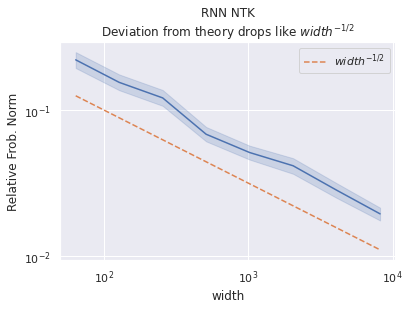

In [13]:
sns.lineplot(data=frob_df, x='width', y='relfrob')
widths = frob_df.width.unique()
plt.plot(widths, np.array(widths, dtype='float')**-0.5, '--', label=u'${width}^{-1/2}$')
plt.ylabel(u'Relative Frob. Norm')
plt.loglog()
plt.legend()
_ = plt.title(u'RNN NTK\nDeviation from theory drops like $width^{-1/2}$')

In [14]:
frob_df.to_pickle('rnn_ap_ntk.frob')